# Multilayer/bilateral matching simulation

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.simulations import er_corr
from pkg.io import FIG_PATH, OUT_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.match import GraphMatchSolver
from pkg.plot import set_theme
from tqdm import tqdm

DISPLAY_FIGS = True

FILENAME = "multilayer_for_bilateral"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)
np.random.seed(88888888)

## Model

In [2]:
n_side = 10
glue("n_side", n_side)
n_sims = 1000
glue("n_sims", n_sims, form="long")
ipsi_rho = 0.8
glue("ipsi_rho", ipsi_rho)
ipsi_p = 0.3
glue("ipsi_p", ipsi_p)
contra_p = 0.2
glue("contra_p", contra_p)

- Let the directed, correlated Erdos-Reyni model be written as $CorrER(n, p, \rho)$, where $n$ is
  the number of nodes, $p$ is the density, and $\rho$ is the correlation between the
  two networks.
- The ipsilateral subgraphs were sampled from a $CorrER$ model:
  - $A_{LL}^{'}, A_{RR}^{'} \sim CorrER(${glue:text}`multilayer_for_bilateral-n_side`, {glue:text}`multilayer_for_bilateral-ipsi_p`, {glue:text}`multilayer_for_bilateral-ipsi_rho`$)$
- Independently from the ipsilateral networks, the contralateral subgraphs were also sampled from a $CorrER$ model:
  - $A_{LR}^{'}, A_{RL}^{'} \sim CorrER(${glue:text}`multilayer_for_bilateral-n_side`, {glue:text}`multilayer_for_bilateral-contra_p`, $\rho_{contra})$
- The full network was then defined as
  - $A^{'} = \begin{bmatrix} A_{LL}^{'} & A_{LR}^{'}\\  A_{RL}^{'} & A_{RR}^{'} \end{bmatrix}$
- A random permutation was applied to the nodes of the "right hemisphere" in each sampled network:
  - $A = \begin{bmatrix} I_n & 0 \\ 0 & P_{rand} \end{bmatrix} A{'} \begin{bmatrix} I_n & 0 \\ 0 & P_{rand} \end{bmatrix}^T = \begin{bmatrix} A_{LL}^{'} & A_{LR}^{'} P_{rand}^T \\  P_{rand} A_{RL}^{'} & P_{rand} A_{RR}^{'} P_{rand}^T \end{bmatrix}$
  - Thus we can write
    - $A_{LL} = A_{LL}^{'}$
    - $A_{RR} = P_{rand} A_{RR}^{'} P_{rand}^T$
    - $A_{LR} = A_{LR}^{'} P_{rand}^T$
    - $A_{RL} = P_{rand} A_{RL}^{'} $

## Experiment
- $\rho_{contra}$ was varied from 0 to 1.
- For each value of $\rho_{contra}$, {glue:text}`multilayer_for_bilateral-n_sims` networks were sampled according to the model above.
- For each sampled network, three algorithms were applied to try to recover the alignment between the left and the right:
  - Graph matching **(GM)**, using only the ipsilateral subgraphs $A_{LR}$ and $A_{RR}$.
    - $\min_{P} \|A_{LL} - P A_{RR} P^T\|_F^2$
  - Bilateral graph matching **(BGM)**, using ipsilateral and contralateral subgraphs:
    - $\min_{P} \|A_{LL} - P A_{RR} P^T\|_F^2 + \|A_{LR} P^T - P A_{RL}\|_F^2$
  - Multilayer graph matching **(MGM)**, using ipsilateral and contralateral subgraphs:
    - $\min_{P} \|A_{LL} - P A_{RR} P^T\|_F^2 + \|A_{LR} - P A_{RL} P^T\|_F^2$
- All algorithms were run with the same (default) settings: one initialization at the barycenter,
  maximum 30 Frank-Wolfe (FW) iterations, stopping tolerance (on the norm of the difference
  between solutions at each FW iteration) of 0.01.
- For each sampled network and algorithm, we computed the matching accuracy for the
  recovered permutation.

In [3]:

rows = []
for contra_rho in np.linspace(0, 1, 11):
    for sim in tqdm(range(n_sims), leave=False):
        # simulate the correlated subgraphs
        A, B = er_corr(n_side, ipsi_p, ipsi_rho, directed=True)
        AB, BA = er_corr(n_side, contra_p, contra_rho, directed=True)

        # permute one side as appropriate
        perm = rng.permutation(n_side)
        undo_perm = np.argsort(perm)
        B = B[perm][:, perm]
        AB = AB[:, perm]
        BA = BA[perm, :]

        # run the matching
        for method in ["GM", "BGM", "MGM"]:
            if method == "GM":
                solver = GraphMatchSolver(A, B)
            elif method == "BGM":
                solver = GraphMatchSolver(A, B, AB=AB, BA=BA)
            elif method == "MGM":
                solver = GraphMatchSolver([A, AB], [B, BA])
            solver.solve()
            match_ratio = (solver.permutation_ == undo_perm).mean()

            rows.append(
                {
                    "ipsi_rho": ipsi_rho,
                    "contra_rho": contra_rho,
                    "match_ratio": match_ratio,
                    "sim": sim,
                    "method": method,
                }
            )

results = pd.DataFrame(rows)

## Results
Below, the mean matching accuracy is plotted as a function of the strength of the
contralateral correlation $\rho_{contra}$ for each of the three algorithms. Shaded
regions show 95% confidence intervals.

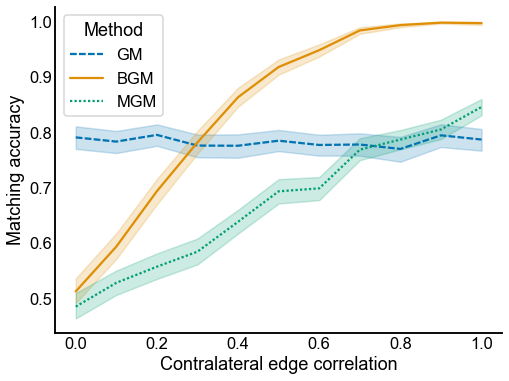

In [4]:

colors = sns.color_palette("colorblind")
method_palette = dict(zip(["GM", "BGM", "MGM"], colors))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(
    data=results,
    x="contra_rho",
    y="match_ratio",
    hue="method",
    style="method",
    hue_order=["GM", "BGM", "MGM"],
    dashes={"GM": (3, 1), "BGM": "", "MGM": (1, 1)},
    ax=ax,
    palette=method_palette,
)
ax.set_ylabel("Matching accuracy")
ax.set_xlabel("Contralateral edge correlation")
sns.move_legend(ax, loc="upper left", title="Method", frameon=True)
gluefig("match_ratio_by_contra_rho", fig)

In [5]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:35.849968
Completed at 2022-05-04 11:16:21.705429
